# Import libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms

# Prepare data

In [0]:
#specify all data paths here
csv_path = 'train.csv'
train_img_path = 'img/'
test_img_path = ''

In [0]:
train_csv = pd.read_csv(csv_path)
train_csv.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [0]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [0]:
class ImageData(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset

        if self.subset == "train":
            self.data_path = train_img_path
        elif self.subset == "test":
            self.data_path = test_img_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        fn = self.df['ImageId'].iloc[index]
        img = Image.open(self.data_path + fn)
        img = self.transform(img)

        def __getitem__(self, index):                      
            fn = self.df['ImageId_ClassId'].iloc[index].split('_')[0]         
            img = Image.open(self.data_path + fn)
            img = self.transform(img)

        if self.subset == 'train': 
            mask = rle2mask(self.df['EncodedPixels'].iloc[index], (256, 1600))
            mask = transforms.ToPILImage()(mask)            
            mask = self.transform(mask)
            return img, mask
        else: 
            mask = None
            return img 
        


In [0]:
data_transf = transforms.Compose([
                                  transforms.Resize((256, 256)),
                                  transforms.ToTensor()])
train_data = ImageData(df = train_csv, transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size=4)

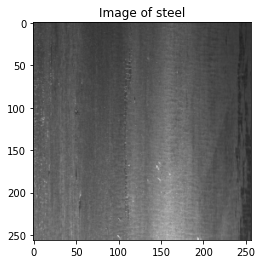

In [0]:
plt.title('Image of steel')
plt.imshow(train_data[0][0].permute(1, 2, 0))

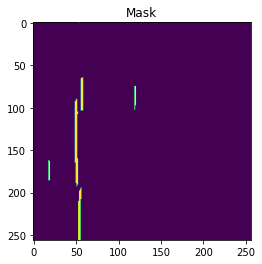

In [0]:
plt.title('Mask')
plt.imshow(np.squeeze(train_data[0][1].permute(1, 2, 0)))

# U-net training

In [0]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        #self.base_model.load_state_dict_from_url(torch.load("../input/resnet18/resnet18.pth"))
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [0]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

model = UNet(n_class=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = 0.001, momentum=0.9)

In [0]:
%%time
epochs = 5
for epoch in range(epochs):      
    model.train()         
    for ii, (data, target) in enumerate(train_loader):                         
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)  
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()    
      
    print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))

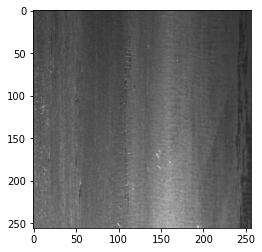

In [0]:
plt.imshow(train_data[0][0].permute(1, 2, 0))

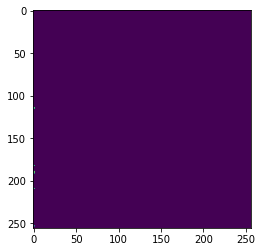

In [0]:
x = train_data[0][0].unsqueeze(0)
o = model(x.to(device))  
o = o.cpu().detach().numpy() * (-1)
tmp = np.copy(o)
mn = np.mean(o)*1.2
tmp[tmp<mn] = 0
tmp[tmp>mn] = 1

plt.imshow(np.squeeze(tmp))

# Reading video & displaying mask

In [0]:
#from google.colab.patches import cv2_imshow

In [0]:
def evaluate_video(img_s, model=model):
    model.eval()

    img_s = cv2.resize(img_s, (256, 256))

    tens = torch.from_numpy(img_s)
    tens = tens.permute(2, 1, 0)
    tens = tens.unsqueeze(0)
    tens = tens.type('torch.FloatTensor')

    pred_o = model(tens.to(device)) 
    pred_o = pred_o.cpu().detach().numpy() * (-1)

    tmp_o = np.copy(pred_o)
    mn_o = np.mean(tmp_o)*1.2
    tmp_o[tmp_o<mn_o] = 0
    tmp_o[tmp_o>mn_o] = 1

    tmp_o = np.flipud(np.rot90(np.squeeze(tmp_o*255), k=1))

    return (tmp_o)

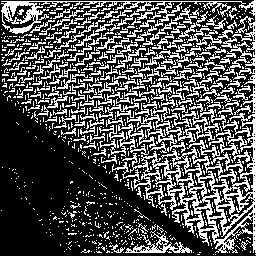

In [0]:
#test mask prediction fuction with image
imgs = evaluate_video(cv2.imread('steel_1.jpg'))
cv2.imshow(imgs)

In [0]:
def pred_mask(vid_file='videoplayback'):
    model.eval()

    cap = cv2.VideoCapture(vid_file)

    while True:
      ret, frame = cap.read()

      imgs = evaluate_video(frame)

      cv2.imshow((cv2.resize(frame, (256, 256))))
      cv2.imshow(imgs)

In [0]:
#specifiy video file if needed
#else uses default file name provide
#during function definition
pred_mask()

# Loading saved model

In [0]:
model = torch.load('test-ste')

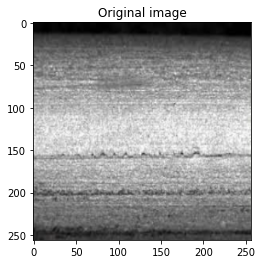

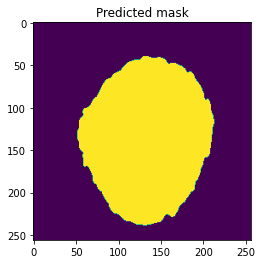

In [0]:
evaluate(img='steel_test.jpeg')

# Utils

In [0]:
def evaluate(img='steel_1.jpg', model=model):
    model.eval()

    #specify test image path here
    test_img = img

    img_s = cv2.imread(test_img)

    img_s = cv2.resize(img_s, (256, 256))
    plt.title('Original image')
    plt.imshow(img_s)
    plt.show()

    tens = torch.from_numpy(img_s)
    tens = tens.permute(2, 1, 0)
    tens = tens.unsqueeze(0)
    tens = tens.type('torch.FloatTensor')

    pred_o = model(tens.to(device)) 
    pred_o = pred_o.cpu().detach().numpy() * (-1)

    tmp_o = np.copy(pred_o)
    mn_o = np.mean(tmp_o)*1.2
    tmp_o[tmp_o<mn_o] = 0
    tmp_o[tmp_o>mn_o] = 1

    plt.title('Predicted mask')
    plt.imshow(np.flipud(np.rot90(np.squeeze(tmp_o*255), k=1)))
    plt.show()

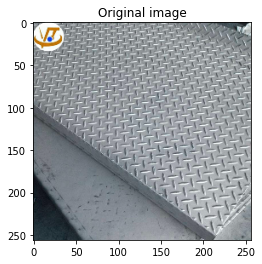

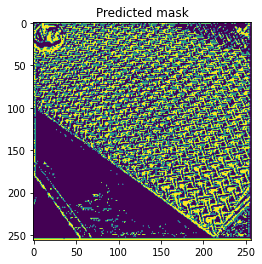

In [0]:
evaluate()

In [0]:
tens = torch.from_numpy(frame)
tens = tens.permute(2, 1, 0)
tens = tens.unsqueeze(0)

pred_o = model(tens.to(device)) 
pred_o = pred_o.cpu().detach().numpy() * (-1)

tmp_o = np.copy(pred_o)
mn_o = np.mean(temp_o)*1.2
tmp_o[tmp_o<mn_o] = 0
tmp_o[tmp_o>mn_o] = 1

if ret == True:
    cv2.imshow('Frame', np.squeeze(tmp_o))